In [1]:
import geopandas as gpd

C:\Users\YAGA\anaconda3\envs\taxonomy\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
class SpaceConn:
    def __init__(self):
        path = "../files/buildings_230221.shp"
        path2="../files/hebing0413.shp"
        self.gdf_hebing=gpd.read_file(path2)
        self.gdf_hebing=self.gdf_hebing.set_index('合并')
        self.buildings = gpd.read_file(path)

    def getIntersectArea(self,x):
        bid=x['bid']
        hbid=x['index_right']
        area=(self.buildings.at[bid,'geometry'] & self.gdf_hebing.at[int(hbid),'geometry']).area
        return area

    def getAggFeatures(self,df):
        df['Elevation']=df['Elevation'].max()
        idx=df['Shape_Area_left'].idxmax()
        df=df.loc[idx]
        return df


    def run(self):

        self.buildings['bid']=self.buildings.index.values
        gdf_conn=gpd.sjoin(self.buildings,self.gdf_hebing,how='left').dropna(subset=['index_right'],axis=0)
        gdf_conn['intersec_area']=gdf_conn.apply(self.getIntersectArea,axis=1)
        gdf_conn=gdf_conn.reset_index(drop=True)
        idx=gdf_conn.groupby('OBJECTID_1')['intersec_area'].idxmax()
        gdf_conn=gdf_conn.loc[idx]
        gdf_conn['index_right']=gdf_conn['index_right'].apply(lambda x:int(x))
        gdf_conn=gdf_conn.groupby(['index_right'],as_index=False).apply(self.getAggFeatures)
        gdf_hebing = self.gdf_hebing.loc[:, ['geometry']].copy()
        gdf_hebing['hbid'] = gdf_hebing.index
        gdf_conn['geometry']=gdf_conn.apply(lambda x:gdf_hebing.geometry[x['index_right']],axis=1)
        gdf_conn.plot()
        gdf_conn['Shape_Leng']=gdf_conn['Shape_Leng_right']
        gdf_conn['Shape_Area']=gdf_conn['Shape_Area_right']
        gdf_conn=gdf_conn.loc[:,['Elevation','功能大','材质大','Text','建筑产','风貌分','geometry','Shape_Leng','Shape_Area']]

        gdf_conn.to_parquet('../files/buildings_hebing_0413.parquet')

C:\Users\YAGA\AppData\Local\Temp\ipykernel_19752\3626648806.py:40: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf_conn.to_parquet('../files/buildings_hebing_0413.parquet')


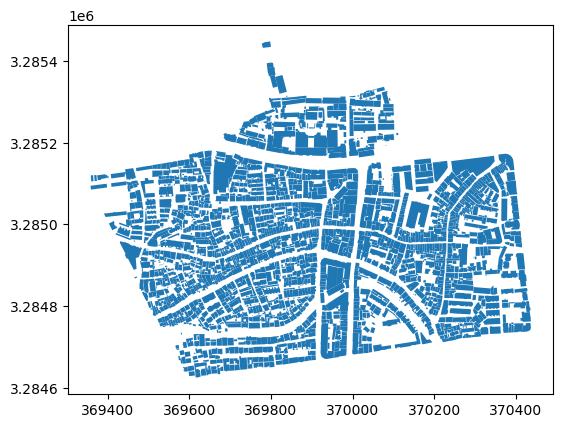

In [3]:
sc=SpaceConn()
sc.run()